In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu


In [2]:


# Mount Google Drive (only needed if running in Google Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define the base path
figure_path = os.path.join(base_path, "figures/")
pathCSV = os.path.join(base_path, 'data/cytometry/')
print(f"[INFO] Looking for CSV files in: {pathCSV}")

# List of file names
csv_files = ['exp1_cytometry_VIP.csv', 'exp2_cytometry_VIP.csv', 'exp3_cytometry_VIP.csv']

# Load all files into a list of DataFrames
df_list = []
for file in csv_files:
    file_path = os.path.join(pathCSV, file)
    df = pd.read_csv(file_path)
    df_list.append(df)

# Combine all data into a single DataFrame
df_combined = pd.concat(df_list, ignore_index=True)

# Display basic info
print("[INFO] Data successfully loaded!")



Mounted at /content/drive
[INFO] Looking for CSV files in: /content/drive/MyDrive/SYNC_Projects/VIP205/data/cytometry/
[INFO] Data successfully loaded!


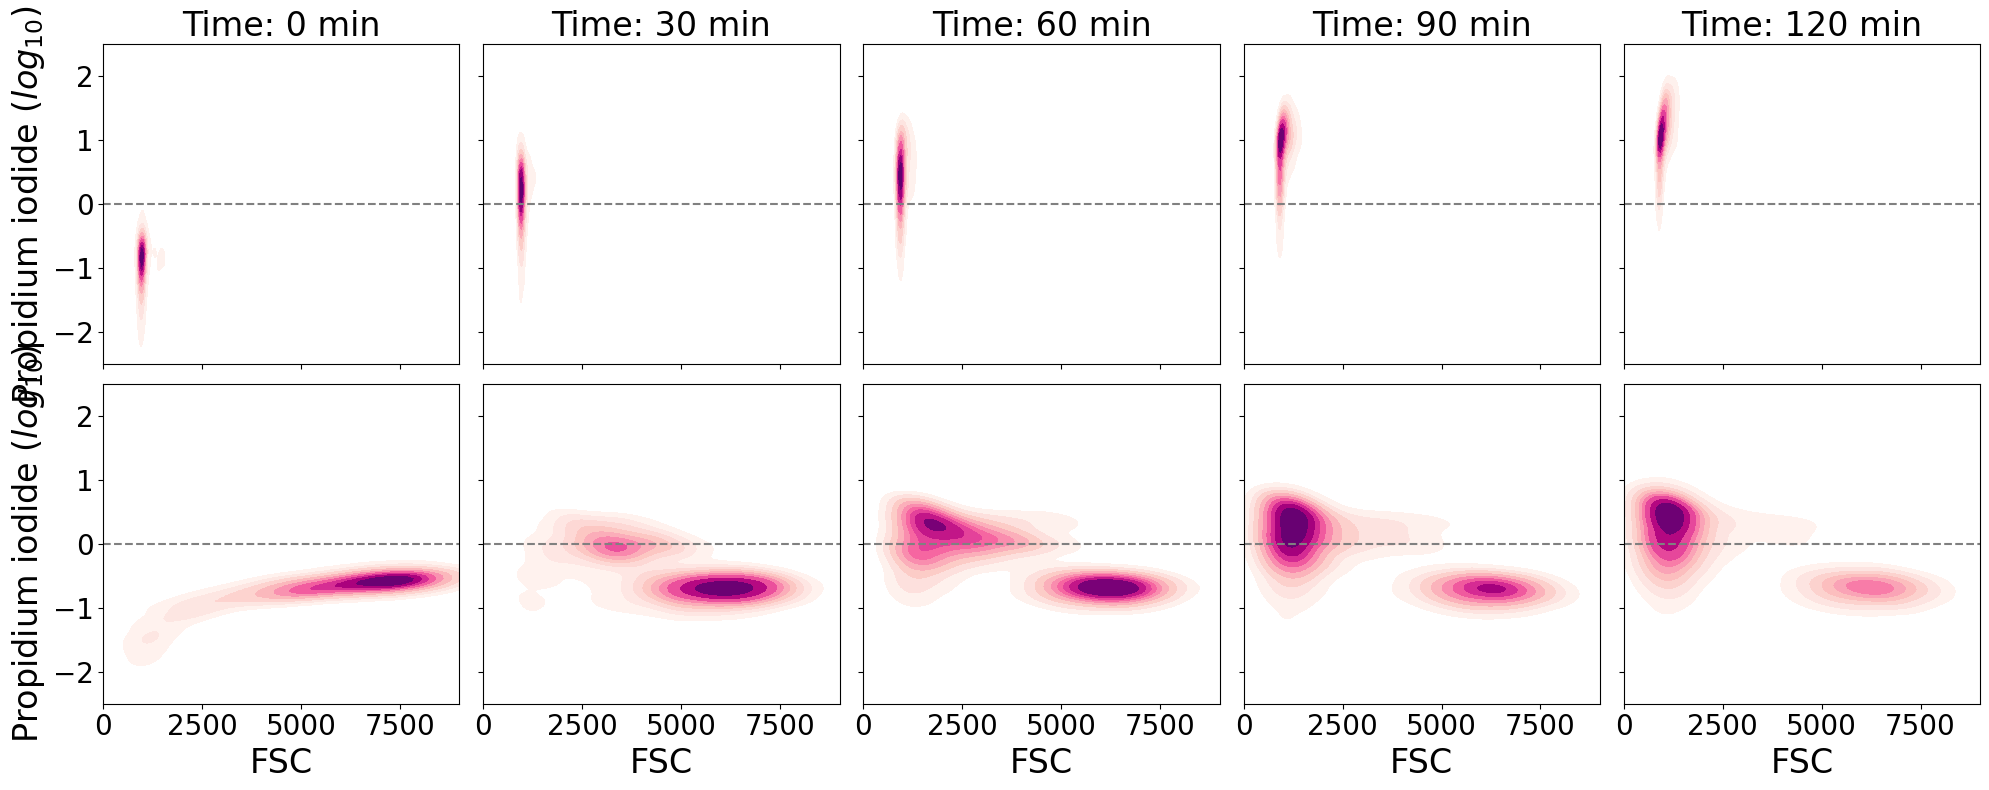

In [3]:

# Filter dataset for experiment 3 and make a copy
df_exp3 = df_combined[df_combined['experiment'] == 'exp3'].copy()

# Ensure correct data types
df_exp3['time'] = df_exp3['time'].astype(int)

# Define unique time points and states
time_points = sorted(df_exp3['time'].unique())
states = ["VIP205+IPTG", "VIP205"]

# Create the figure with two rows (states) and columns for unique time points
fig, axes = plt.subplots(nrows=2, ncols=len(time_points), figsize=(len(time_points) * 4, 8), sharex=True, sharey=True)

# Iterate over states and time points to create subplots
for row_idx, state in enumerate(states):
    for col_idx, time in enumerate(time_points):
        ax = axes[row_idx, col_idx]

        # Filter data for current state and time point
        subset = df_exp3[(df_exp3['state'] == state) & (df_exp3['time'] == time)]

        # Plot density instead of scatter points
        sns.kdeplot(data=subset, x="cell_length", y="propidium_iodide", fill=True, thresh=0.1, levels=10, cmap="RdPu", ax=ax)

        # Titles and labels
        if row_idx == 0:
            ax.set_title(f"Time: {time} min", fontsize=24)
        if col_idx == 0:
            ax.set_ylabel(r"Propidium iodide ($log_{10}$)", fontsize=24)
        else:
            ax.set_ylabel("")

        ax.set_ylim([-2.5, 2.5])
        ax.set_xlim([0, 9e3])
        ax.set_xlabel("FSC", fontsize=24)
        ax.tick_params(labelsize=20)
        ax.axhline(0, linestyle="--", color="gray", linewidth=1.5)


# Adjust layout
plt.tight_layout()
plt.show()


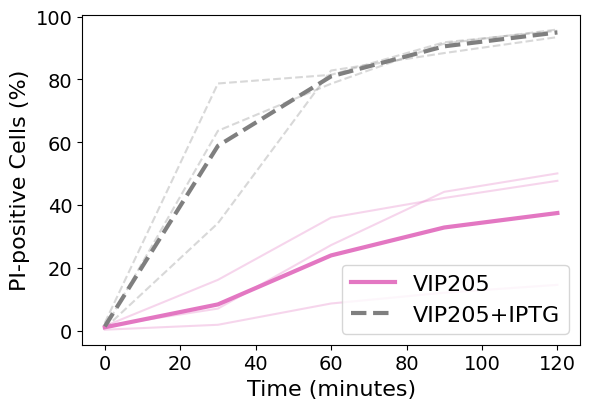

In [4]:


# Ensure correct data types
df_combined['time'] = df_combined['time'].astype(int)

# Compute the fraction of PI-positive ("dead") cells per time, experiment, and state
df_pi_fraction = df_combined.groupby(['time', 'experiment', 'state'])['PI_classification'].apply(lambda x: (x == 'dead').mean()).reset_index()

# Rename the column for clarity
df_pi_fraction.rename(columns={'PI_classification': 'PI_positive_fraction'}, inplace=True)

# Convert fraction to percentage
df_pi_fraction['PI_positive_fraction'] *= 100

# Create the plot
plt.figure(figsize=(6, 4.2))

# Define colors
palette = {'VIP205+IPTG': 'tab:grey', 'VIP205': 'tab:pink'}

# Plot individual experiment replicates in light color
for exp in df_pi_fraction['experiment'].unique():
    for state in df_pi_fraction['state'].unique():
        subset = df_pi_fraction[(df_pi_fraction['experiment'] == exp) & (df_pi_fraction['state'] == state)]
        linestyle = "--" if state == "VIP205+IPTG" else "-"
        sns.lineplot(data=subset, x="time", y="PI_positive_fraction", color=palette[state], linestyle=linestyle, alpha=0.3)

# Compute mean across experiments
df_pi_mean = df_pi_fraction.groupby(['time', 'state'])['PI_positive_fraction'].mean().reset_index()

# Plot mean curves with thick lines
for state in df_pi_mean['state'].unique():
    subset = df_pi_mean[df_pi_mean['state'] == state]
    linestyle = "--" if state == "VIP205+IPTG" else "-"
    sns.lineplot(data=subset, x="time", y="PI_positive_fraction", color=palette[state], linestyle=linestyle, linewidth=3, label=state)

# Labels and title
plt.xlabel("Time (minutes)", fontsize=16)
plt.ylabel("PI-positive Cells (%)", fontsize=16)
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show plot
plt.tight_layout()
plt.show()



=== Survival Statistics by Condition ===

VIP205 - Mann-Whitney U Test:
  Survived (n=102209): Mean Length = 2878.48 µm ± 2111.34
  Not Survived (n=28340): Mean Length = 1828.10 µm ± 996.87
  U-statistic: 1.81e+09
  p-value: 0.000e+00

VIP205+IPTG - Mann-Whitney U Test:
  Survived (n=41811): Mean Length = 1031.55 µm ± 266.90
  Not Survived (n=80436): Mean Length = 1104.78 µm ± 268.66
  U-statistic: 1.32e+09
  p-value: 0.000e+00



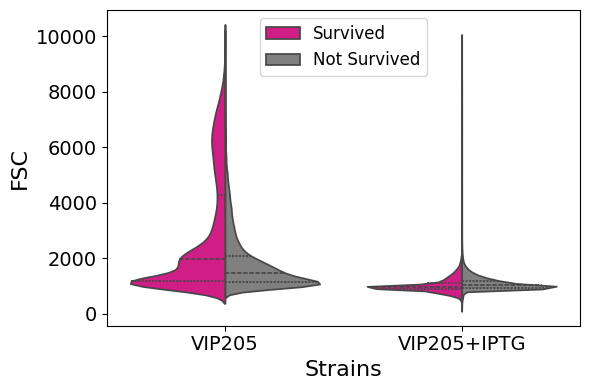

In [5]:

def plot_survival_vs_non_survival_log(df, pixel2um=1):
    """
    Generate a violin plot comparing cell length distributions for survived vs. non-survived cells.
    The y-axis (cell length) is plotted in log scale.

    - VIP205 (Filamentation) on the left
    - VIP205+IPTG (Normal) on the right
    """
    states = ["VIP205", "VIP205+IPTG"]
    labels = {"VIP205": "VIP205", "VIP205+IPTG": "VIP205+IPTG"}

    results = {}

    print("\n=== Survival Statistics by Condition ===\n")

    for state in states:
        subset = df[df['state'] == state].copy()

        # Convert cell lengths to micrometers
        survived = subset[subset['PI_classification'] == "alive"]['cell_length'] * pixel2um
        non_survived = subset[subset['PI_classification'] == "dead"]['cell_length'] * pixel2um

        # Compute statistics
        mean_survived = survived.mean()
        mean_non_survived = non_survived.mean()
        std_survived = survived.std()
        std_non_survived = non_survived.std()

        # Perform Mann-Whitney U test with normal approximation
        if len(survived) > 0 and len(non_survived) > 0:
            stat, p_value = mannwhitneyu(survived, non_survived, alternative='two-sided', method='asymptotic')
        else:
            stat, p_value = None, None

        results[state] = (survived, non_survived, stat, p_value)

        # Print summary statistics
        print(f"{labels[state]} - Mann-Whitney U Test:")
        print(f"  Survived (n={len(survived)}): Mean Length = {mean_survived:.2f} µm ± {std_survived:.2f}")
        print(f"  Not Survived (n={len(non_survived)}): Mean Length = {mean_non_survived:.2f} µm ± {std_non_survived:.2f}")
        print(f"  U-statistic: {stat:.2e}")
        print(f"  p-value: {p_value:.3e}\n")

    # Prepare data for plotting
    plot_data = []
    group_labels = []
    survival_labels = []

    for state in states:
        survived, non_survived, _, _ = results[state]

        if len(survived) > 0:
            plot_data.extend(survived)
            group_labels.extend([labels[state]] * len(survived))
            survival_labels.extend(["Survived"] * len(survived))

        if len(non_survived) > 0:
            plot_data.extend(non_survived)
            group_labels.extend([labels[state]] * len(non_survived))
            survival_labels.extend(["Not Survived"] * len(non_survived))

    # Create the violin plot
    plt.figure(figsize=(6, 4))
    sns.violinplot(x=group_labels, y=plot_data, hue=survival_labels, split=True, inner="quartile",
               palette={"Survived": "#EC008C", "Not Survived": "grey"},
               density_norm="width")  # Use this instead of scale="width"



    # Set log scale for y-axis
    #plt.yscale("log")

    # Formatting
    plt.xlabel("Strains", fontsize=16)
    plt.ylabel(r"FSC", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=12)

    # Show plot
    plt.tight_layout()
    plt.show()

plot_survival_vs_non_survival_log(df_combined)
